In [1]:
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import shap
import re

## 1. 가설 1

## 2. 가설 2

### 2-1. 데이터 시각화 

### 2-2. 변수 검정 

### 2-3. 데이터 전처리 

In [3]:
# 데이터 불러오기 
df = pd.read_csv('./SCALE불량.csv', encoding='cp949')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조


In [4]:
# 변수 선택 
df = df[['plate_no', 'steel_kind', 'hsb', 'fur_heat_temp', 'fur_soak_temp', 'fur_soak_time', 'rolling_method', 'rolling_temp', 'descaling_count', 'scale']]

In [5]:
# 데이터 전처리
# plate_no (문자열 제거)
df['plate_no'] = df['plate_no'].apply(lambda x: int(re.sub(r'\D', '', str(x))))

# scale (양품 = 0, 불량 = 1)
df['scale'] = df['scale'].map(lambda x : 0 if x == '양품' else 1) 
df['scale'].head()

# steel_kind (T = 1, C = 2)
df['steel_kind'] = df['steel_kind'].map({'T': 1, 'C': 2}).astype(int)

# rolling_method (TMCP = 1, CR = 2)
df['rolling_method'] = df['rolling_method'].apply(lambda x: re.sub(r'\W.*$', '', x)) 
df['rolling_method'] = df['rolling_method'].replace({'TMCP': 1, 'CR': 2}).astype(int)

# hsb (적용 = 1, 미적용 = 2)
df['hsb'] = df['hsb'].map({'적용': 1, '미적용': 2}).astype(int)

# 이상치 제거 (rolling_temp 값이 0인 데이터)
df = df[df['rolling_temp'] != 0]

In [6]:
df.head()

,plate_no,steel_kind,hsb,fur_heat_temp,fur_soak_temp,fur_soak_time,rolling_method,rolling_temp,descaling_count,scale
0,1001,1,1,1144,1133,59,1,934,8,0
1,1002,1,1,1144,1135,53,1,937,8,0
2,1003,1,1,1129,1121,55,1,889,8,0
3,1004,1,1,1152,1127,68,1,885,8,0
4,1005,1,1,1140,1128,48,1,873,8,0


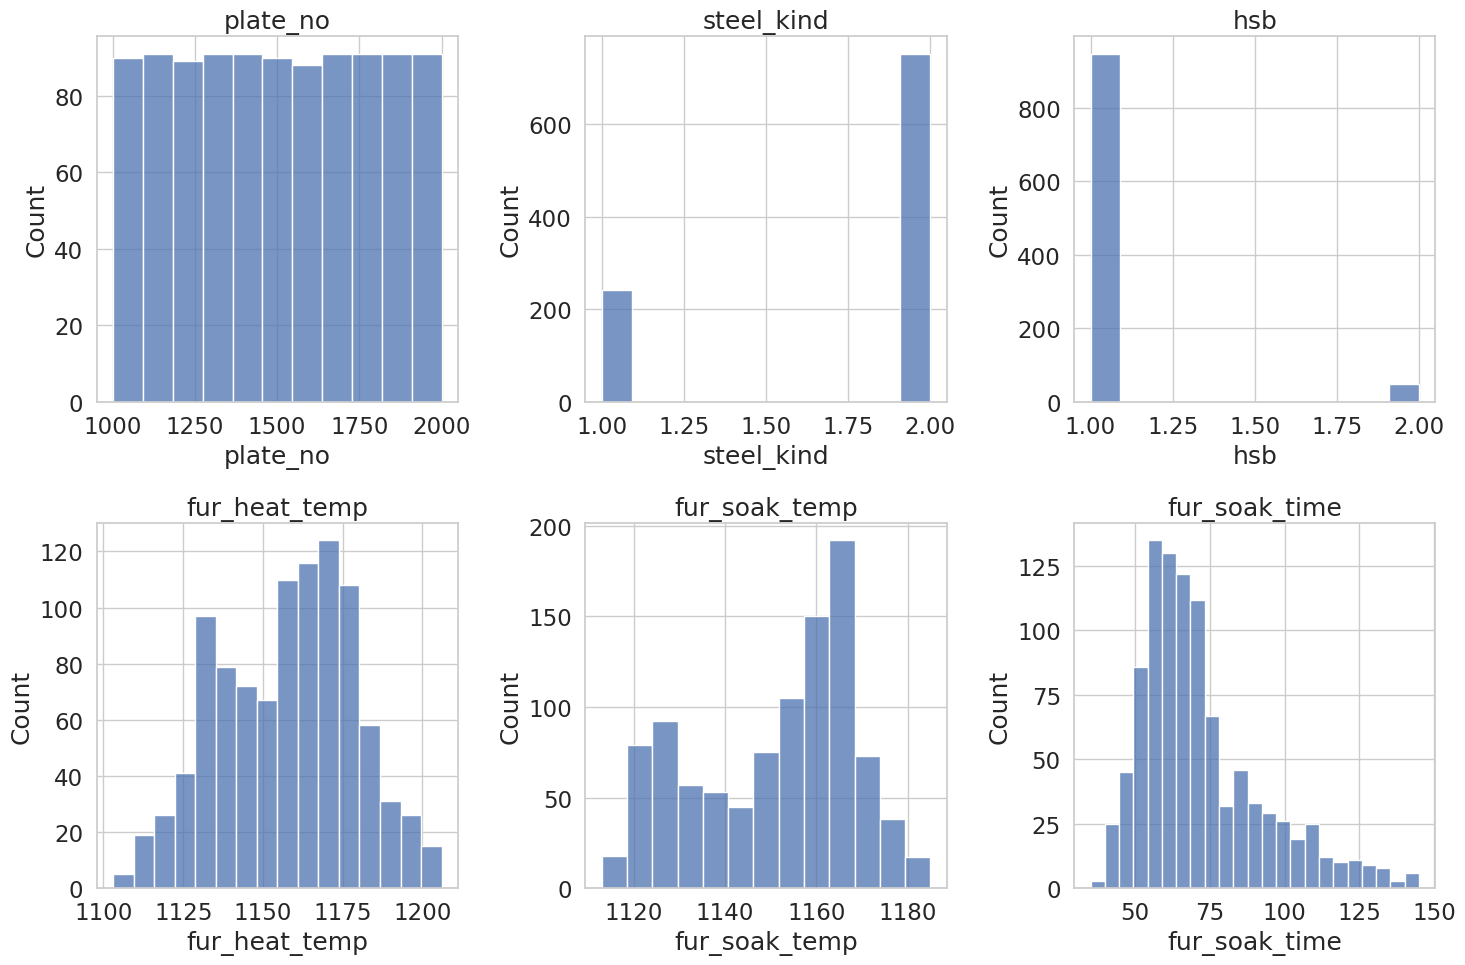

In [7]:
# 시각화할 변수 리스트
columns = ['plate_no', 'steel_kind', 'hsb', 'fur_heat_temp', 'fur_soak_temp', 'fur_soak_time']

# 그래프 설정
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# 변수별로 서브플롯에 그래프 그리기
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [8]:
# # 특성 엔지니어링 - 파생 변수 생성
# df['is_even_descaling'] = df['descaling_count'] % 2 == 0
# df['high_fur_heat_temp'] = df['fur_heat_temp'] > 1200
# df['high_fur_soak_temp'] = df['fur_soak_temp'] > 1175
# df['high_rolling_temp'] = df['rolling_temp'] > 1000
# df['hsb_unapplied'] = df['hsb'] == 2

### 2-4. 모델 학습 및 평가 

In [9]:
# 입력 변수(X)와 목표 변수(y) 분리
X = df.drop('scale', axis=1)
y = df['scale']

In [10]:
# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1234)

In [11]:
# # 가중치 계산
# sample_weights = np.where(
#     (df.loc[X_train.index, 'steel_kind'] == 'C') & (df.loc[X_train.index, 'scale'] == 1), 4.7, 
#     np.where((df.loc[X_train.index, 'steel_kind'] == 'T') & (df.loc[X_train.index, 'scale'] == 1), 1.0, 1.0)
# )

In [12]:
# 모델 리스트 (기본)
models = {
    "Logistic Regression": LogisticRegression(random_state=1234),
    "Decision Tree": DecisionTreeClassifier(random_state=1234),
    "Random Forest": RandomForestClassifier(random_state=1234),
    "Gradient Boosting": GradientBoostingClassifier(random_state=1234),
    "XGBoost": xgb.XGBClassifier(random_state=1234, use_label_encoder=False, eval_metric='logloss')
}

In [13]:
# 모델 학습 및 평가
results = []
feature_importances = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })
    
    # 변수 중요도 저장 (트리 기반 모델)
    if model_name in ["Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]:
        feature_importances[model_name] = model.feature_importances_

/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.819095   0.755102  0.606557  0.672727  0.819672
1        Decision Tree  0.984925   0.991525  0.959016  0.975000  0.977697
2        Random Forest  0.982412   1.000000  0.942623  0.970464  0.994758
3    Gradient Boosting  0.992462   0.991736  0.983607  0.987654  0.998604
4              XGBoost  0.989950   0.991667  0.975410  0.983471  0.996466


### 2-5. 결과 시각화 

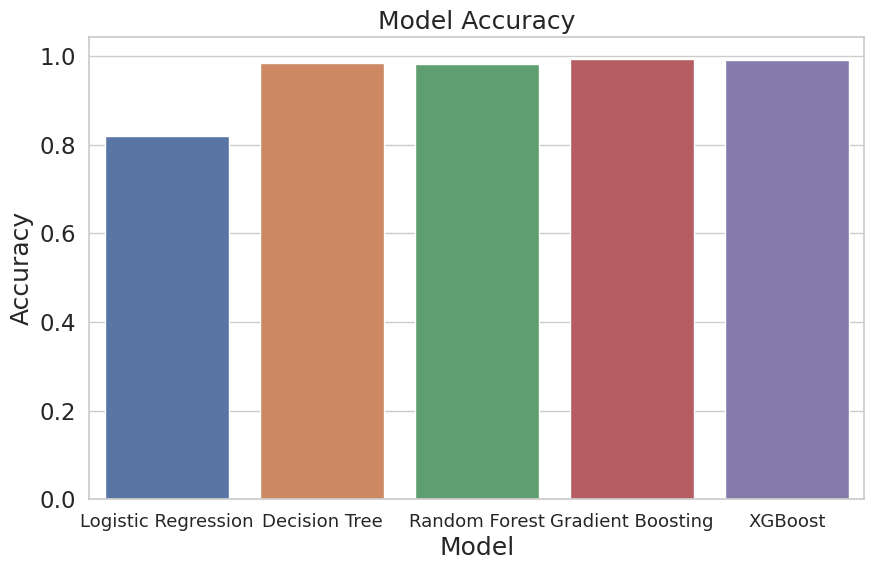

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy')
plt.xticks(fontsize=13)  
plt.show()

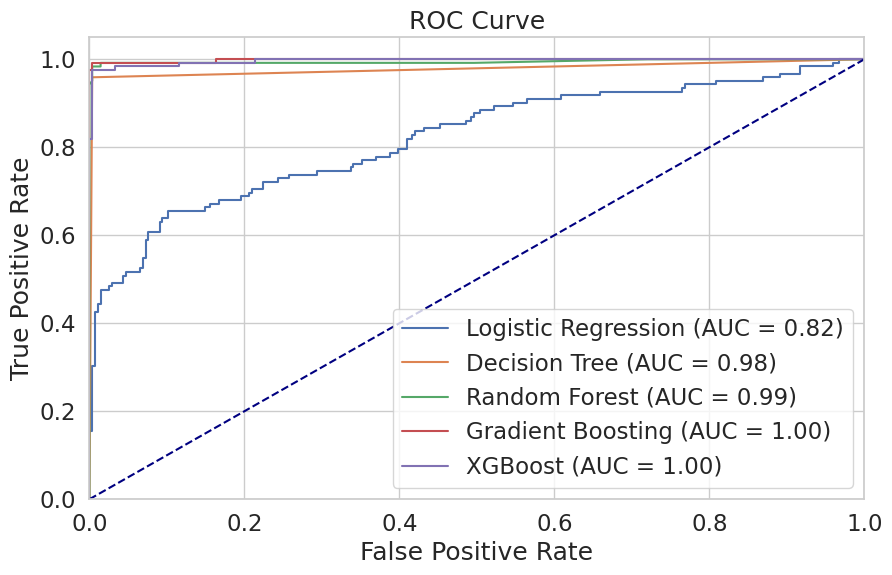

In [16]:
# ROC 곡선 시각화
plt.figure(figsize=(10, 6))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

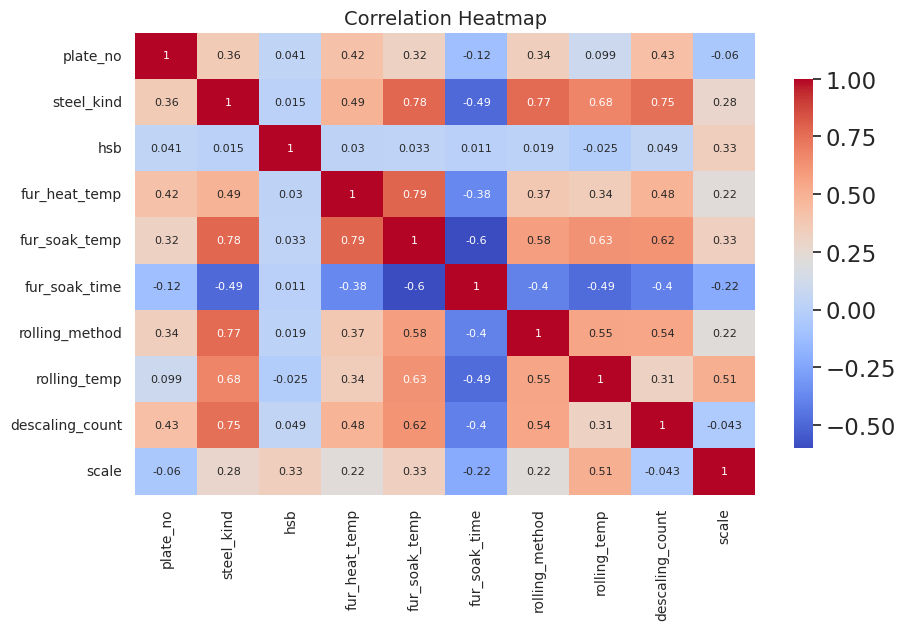

In [20]:
# 상관계수 히트맵
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

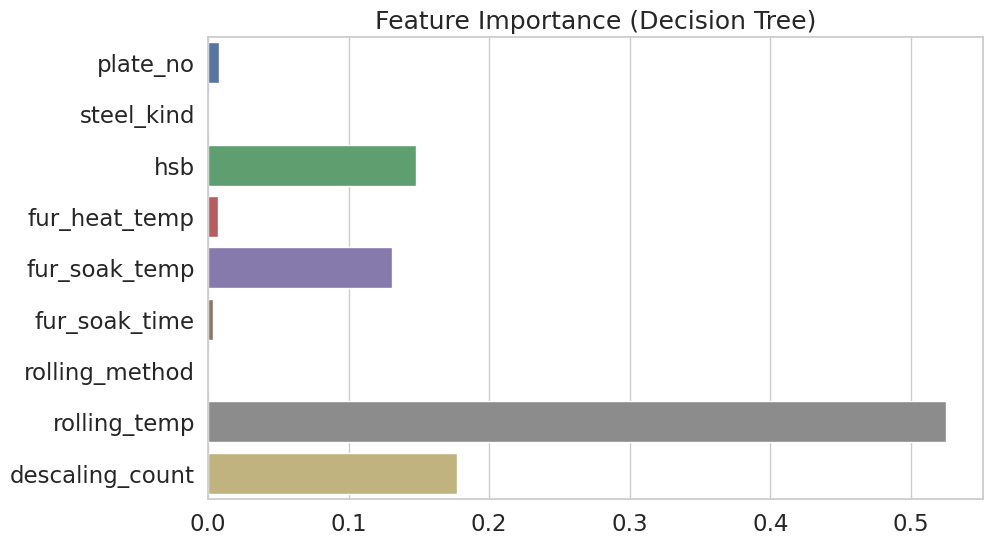

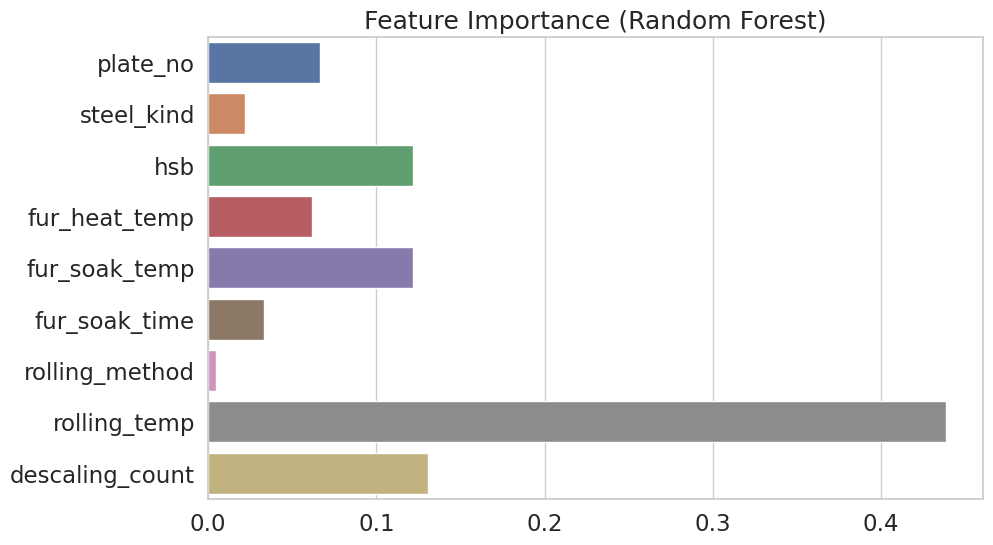

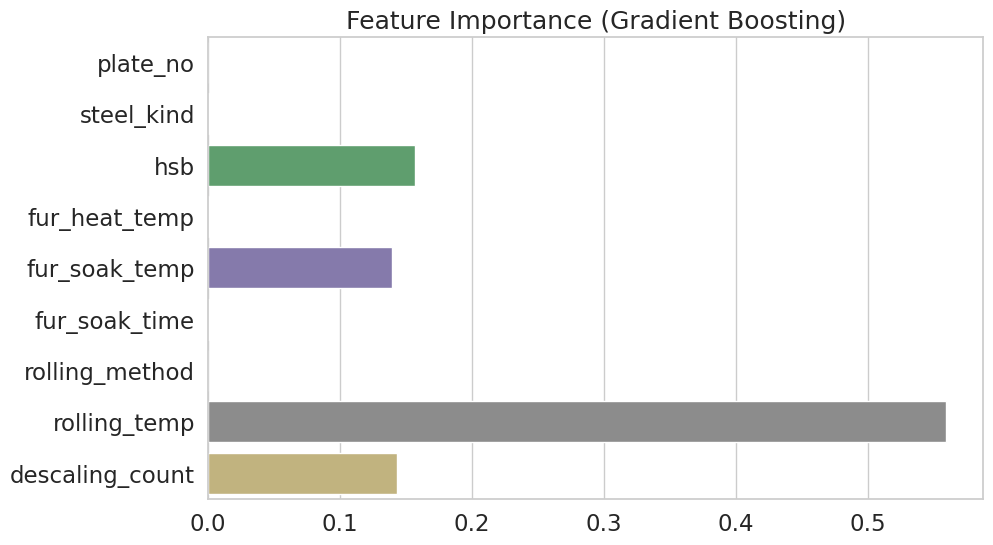

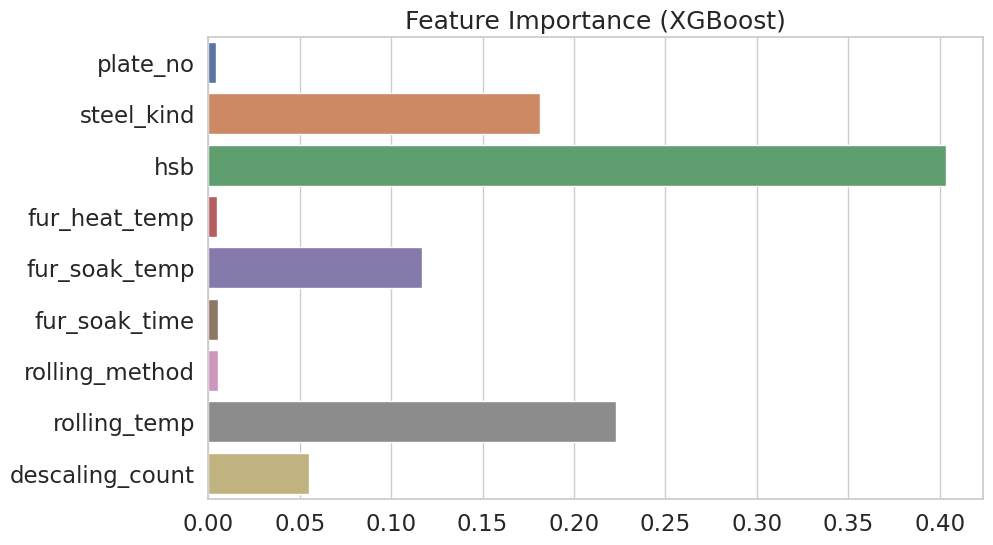

In [17]:
# 변수 중요도 시각화
for model_name, importances in feature_importances.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=X.columns)
    plt.title(f'Feature Importance ({model_name})')
    plt.show()

Using 596 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Processing SHAP analysis for Logistic Regression...


  0%|          | 0/398 [00:00<?, ?it/s]

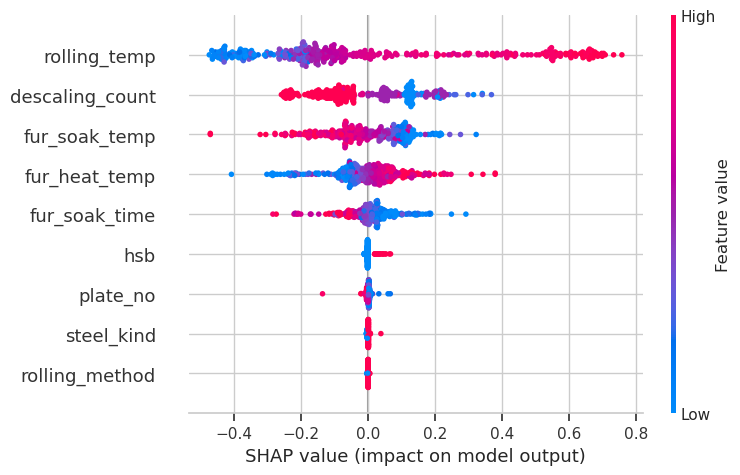

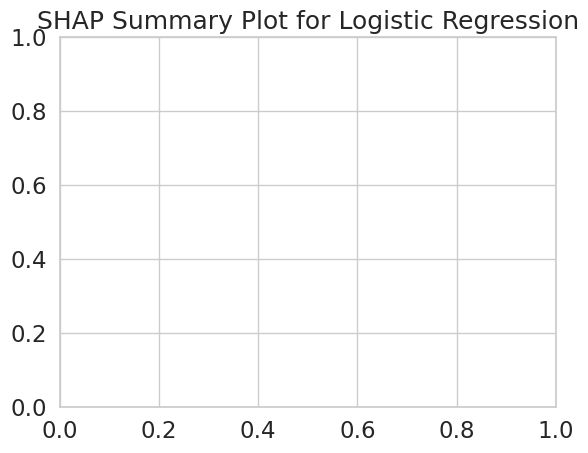

Processing SHAP analysis for Decision Tree...


<Figure size 640x480 with 0 Axes>

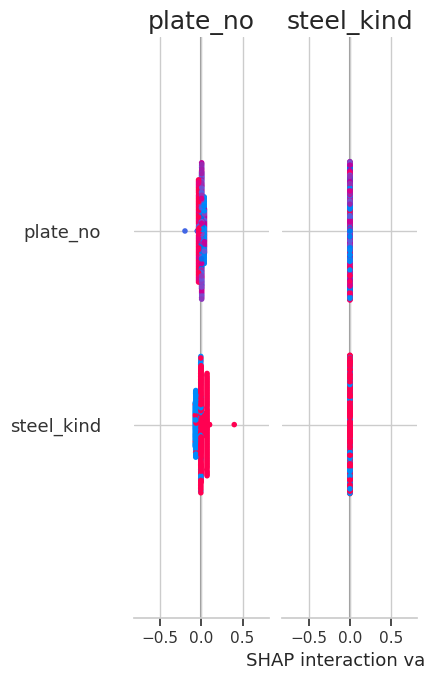

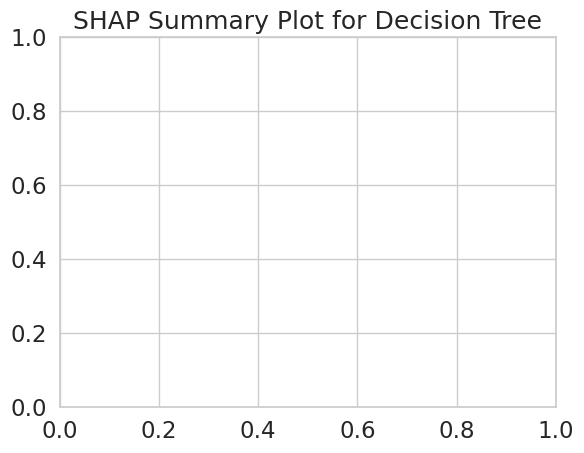

Processing SHAP analysis for Random Forest...


<Figure size 640x480 with 0 Axes>

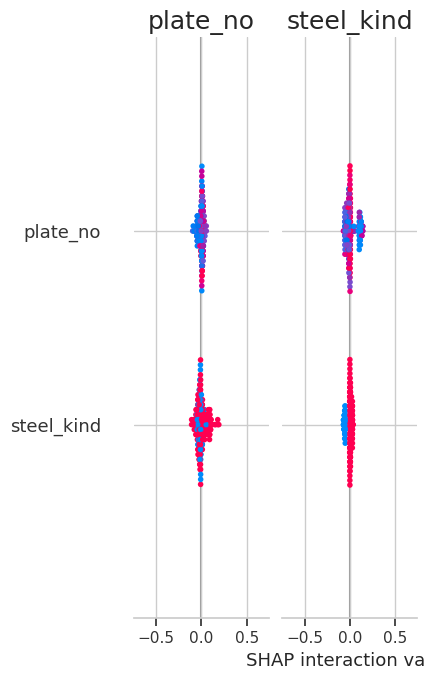

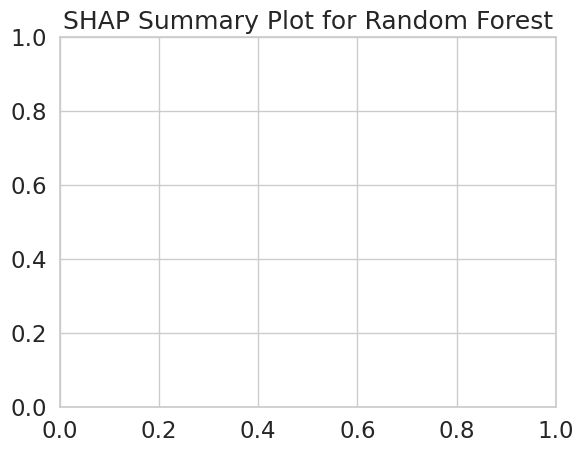

Processing SHAP analysis for Gradient Boosting...


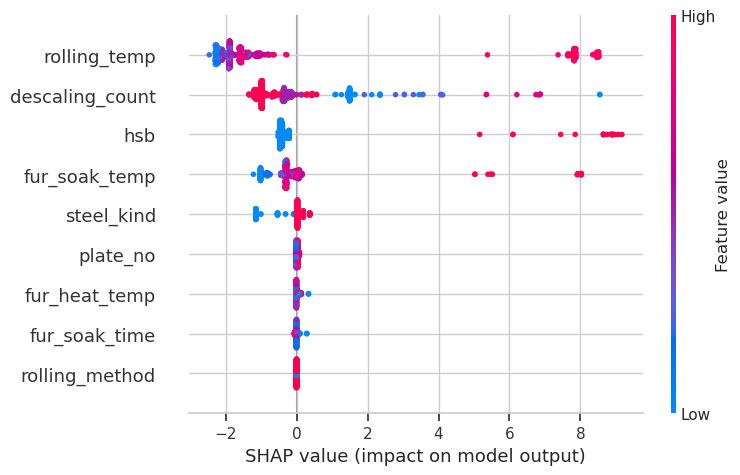

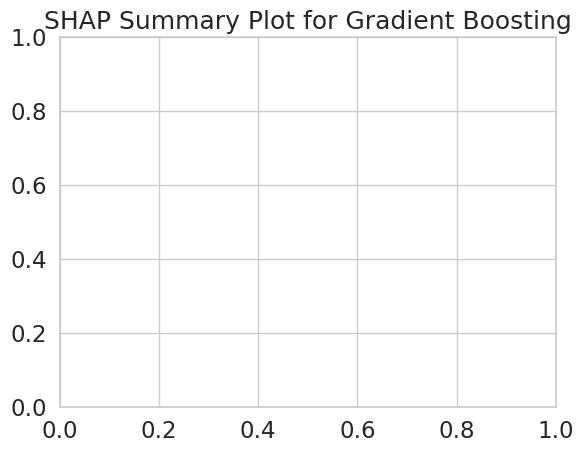

Processing SHAP analysis for XGBoost...


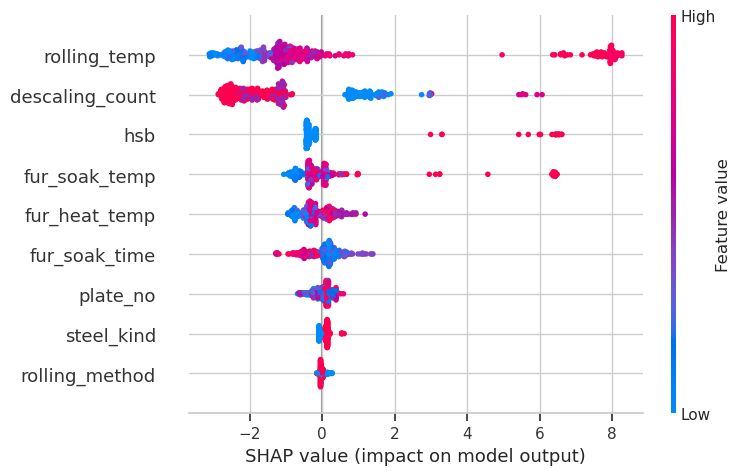

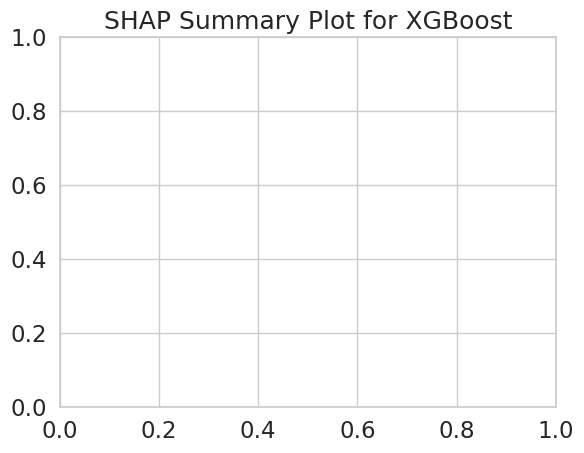

In [18]:
import shap
import matplotlib.pyplot as plt

# SHAP 분석 및 시각화
for model_name, model in models.items():
    print(f"Processing SHAP analysis for {model_name}...")
    
    # 각 모델에 맞는 explainer 생성
    if model_name in ["Random Forest", "Decision Tree", "Gradient Boosting", "XGBoost"]:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # 다중 클래스 분류의 경우 shap_values가 클래스별로 나뉠 수 있음
        if isinstance(shap_values, list) and len(shap_values) > 1:
            shap_values = shap_values[1]  # 두 번째 클래스를 선택하여 사용 (예: 양성 클래스)
        
    else:
        explainer = shap.KernelExplainer(model.predict, X_train)
        shap_values = explainer.shap_values(X_test)
    
    # SHAP 값 시각화
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)
    plt.title(f'SHAP Summary Plot for {model_name}')
    plt.show()